# Data Clean Up (QARTOD)

![](https://imgs.xkcd.com/comics/artifacts.png)


## Quality Assurance/Quality Control (QA/QC) configuration

In [1]:
variable_name = "sea_surface_height_above_sea_level_geoid_mhhw"


qc_config = {
    "qartod": {
        "gross_range_test": {"fail_span": [-10, 10], "suspect_span": [-2, 3]},
        "flat_line_test": {
            "tolerance": 0.001,
            "suspect_threshold": 10800,
            "fail_threshold": 21600,
        },
        "spike_test": {
            "suspect_threshold": 0.8,
            "fail_threshold": 3,
        },
    }
}

## data from the [AOOS ERDDAP server](http://erddap.aoos.org/erddap/)

Note that the data may change in the future. For reproducibility’s sake we will
save the data downloaded into a CSV file.


In [2]:
from pathlib import Path

import pandas as pd
from erddapy import ERDDAP

path = Path().absolute()
fname = path.joinpath("data", "water_level_example.csv")

if fname.is_file():
    data = pd.read_csv(fname, parse_dates=["time (UTC)"])
else:
    e = ERDDAP(server="http://erddap.aoos.org/erddap/", protocol="tabledap")
    e.dataset_id = "kotzebue-alaska-water-level"
    e.constraints = {
        "time>=": "2018-09-05T21:00:00Z",
        "time<=": "2019-07-10T19:00:00Z",
    }
    e.variables = [
        variable_name,
        "time",
        "z",
    ]
    data = e.to_pandas(
        index_col="time (UTC)",
        parse_dates=True,
    )
    data["timestamp"] = data.index.astype("int64") // 1e9
    data.to_csv(fname)

data.head()

,time (UTC),sea_surface_height_above_sea_level_geoid_mhhw (m),z (m),timestamp
0,2018-09-05 21:00:00+00:00,0.4785,0.0,1.536181e+09
1,2018-09-05 22:00:00+00:00,0.4420,0.0,1.536185e+09
2,2018-09-05 23:00:00+00:00,0.4968,0.0,1.536188e+09
3,2018-09-06 01:00:00+00:00,0.5456,0.0,1.536196e+09
4,2018-09-06 02:00:00+00:00,0.5761,0.0,1.536199e+09


## Run the QC

In [3]:
from ioos_qc.config import QcConfig

qc = QcConfig(qc_config)

qc_results = qc.run(
    inp=data["sea_surface_height_above_sea_level_geoid_mhhw (m)"],
    tinp=data["timestamp"],
    zinp=data["z (m)"],
)

qc_results

defaultdict(collections.OrderedDict,
            {'qartod': OrderedDict([('gross_range_test',
                           array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)),
                          ('flat_line_test',
                           array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)),
                          ('spike_test',
                           array([2, 1, 1, ..., 1, 1, 2], dtype=uint8))])})

## Function to plot the results

In [4]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np


def plot_results(data, var_name, results, title, test_name):
    time = data.index
    obs = data[var_name]
    qc_test = results["qartod"][test_name]

    qc_pass = np.ma.masked_where(qc_test != 1, obs)
    qc_suspect = np.ma.masked_where(qc_test != 3, obs)
    qc_fail = np.ma.masked_where(qc_test != 4, obs)
    qc_notrun = np.ma.masked_where(qc_test != 2, obs)

    fig, ax = plt.subplots(figsize=(15, 3.75))
    fig.set_title = f"{test_name}: {title}"

    ax.set_xlabel("Time")
    ax.set_ylabel("Observation Value")

    kw = {"marker": "o", "linestyle": "none"}
    ax.plot(time, obs, label="obs", color="#A6CEE3")
    ax.plot(
        time, qc_notrun, markersize=2, label="qc not run", color="gray", alpha=0.2, **kw
    )
    ax.plot(
        time, qc_pass, markersize=4, label="qc pass", color="green", alpha=0.5, **kw
    )
    ax.plot(
        time,
        qc_suspect,
        markersize=4,
        label="qc suspect",
        color="orange",
        alpha=0.7,
        **kw,
    )
    ax.plot(time, qc_fail, markersize=6, label="qc fail", color="red", alpha=1.0, **kw)
    ax.grid(True)


title = "Water Level [MHHW] [m] : Kotzebue, AK"

## Gross Range test

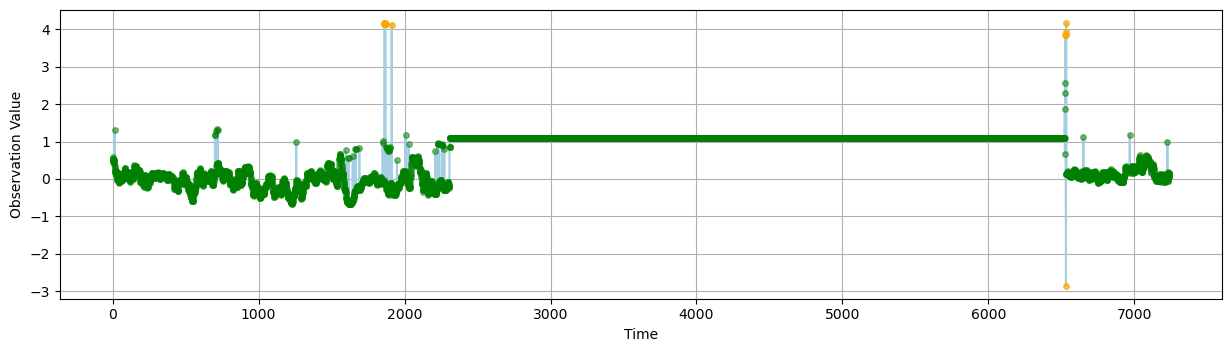

In [5]:
plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "gross_range_test",
)

## Spike test

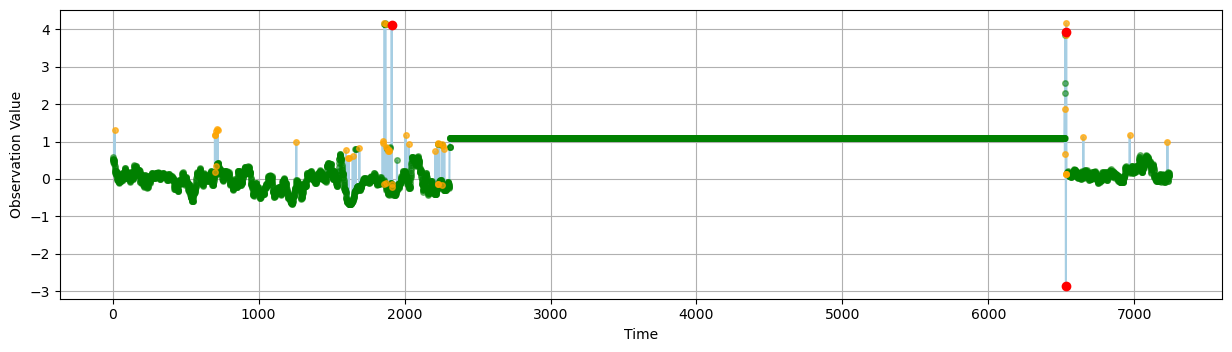

In [6]:
plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "spike_test",
)

## Flat Line test

<IPython.core.display.Javascript object>


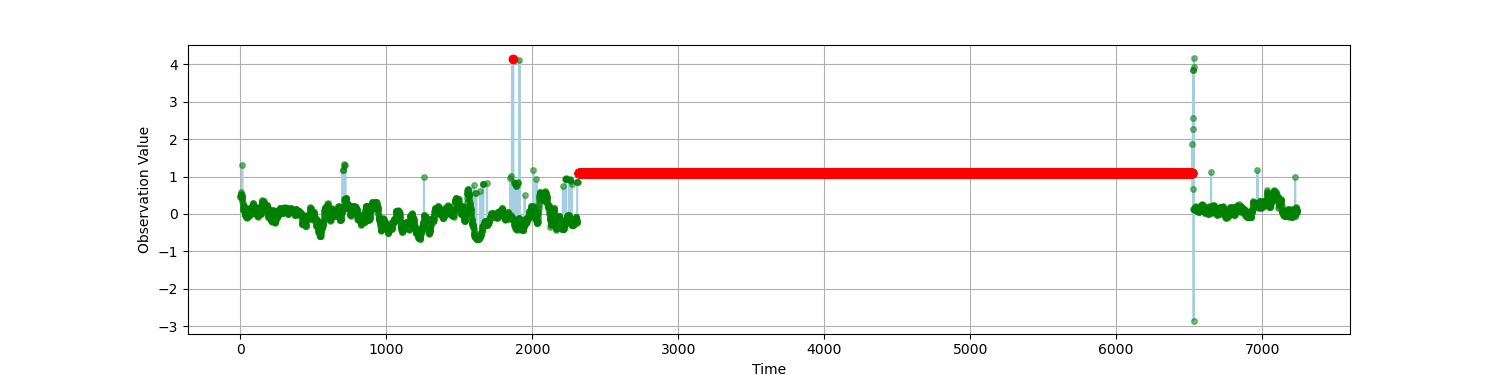

In [7]:
%matplotlib notebook

plot_results(
    data,
    "sea_surface_height_above_sea_level_geoid_mhhw (m)",
    qc_results,
    title,
    "flat_line_test",
)